<a href="https://colab.research.google.com/github/nick-leland/HFT-8-Hour-Dive/blob/main/LSTM_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writing the function to convert into systematic data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def plot_series(series, title=None):
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(series)
    plt.xlabel("Index")
    plt.ylabel("Value")
    if title:
        plt.title(title)
    else:
        plt.title("Time Series Plot")
    plt.grid(True)
    plt.show()

def adjust_price_series(df, jump_threshold=15, price_column='Typical Price'):
    previous = None
    adjustment = 0
    adjusted_ts = []

    for point in df[price_column]:
        if previous is not None:
            difference = abs(point - previous)

            if difference > jump_threshold:
                if point > previous:
                    adjustment -= difference
                else:
                    adjustment += difference

        previous = point
        adjusted_ts.append(point + adjustment)

    return adjusted_ts


def adjusted_portion(dataframe_input, plot=False, adjusted_price=True):
    input = dataframe_input.copy()
    name = input.iloc[0].iloc[0]

    input.drop(0, inplace=True)
    input.drop(1, inplace=True)

    input.drop('Price', axis=1, inplace=True)
    input = input.reset_index(drop=True)

    input['High'] = input['High'].astype(float)
    input['Low'] = input['High'].astype(float)
    input['Close'] = input['High'].astype(float)

    input['Typical Price'] = ((input['High']) + (input['Low']) + (input['Close'])) / 3
    output = input['Typical Price']

    # Plot the
    if plot:
        plot_series(output, title="Time Series Plot")

    if adjusted_price:
        output = adjust_price_series(input)
        output = pd.Series(output)
        plot_series(output, title="Time Series Plot Adjusted")

    output.to_csv('TSLA_TS.csv', index=False, index_label=False, header=False)
    return output


In [5]:
df = pd.read_csv("/content/drive/MyDrive/TSLA.csv")

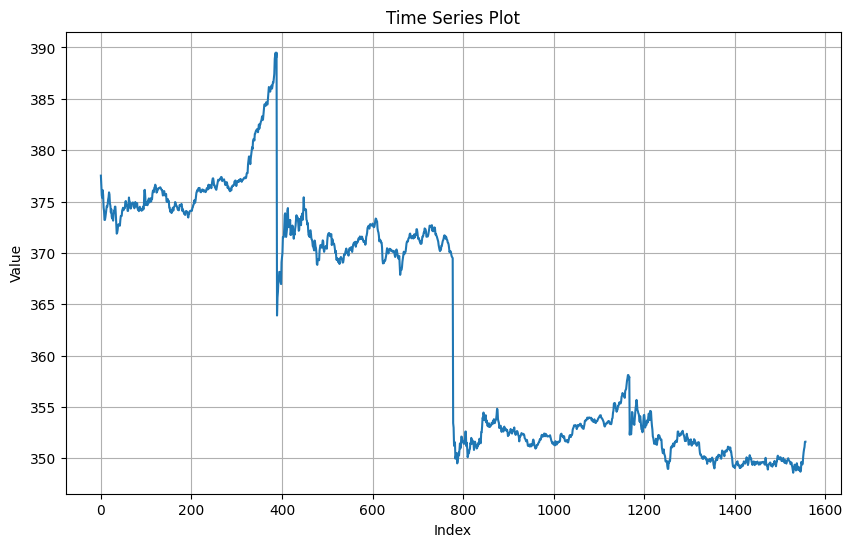

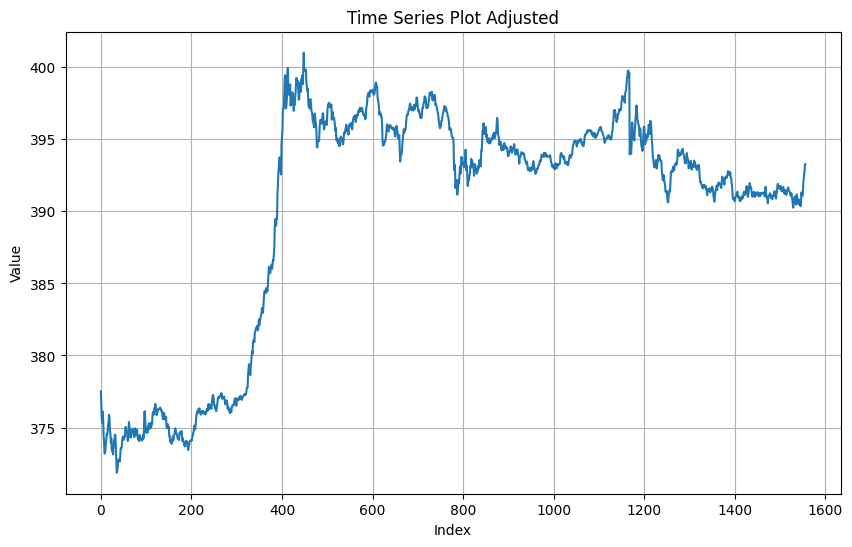

In [6]:
df = adjusted_portion(df, plot=True)

# Apply this for multiple files

Change the boolean below if you would like to scrap files, otherwise assume copying from drive.

TODO:
- Change the adjustment function so that it can work on files that are already transformed into a series
- Add the function to scrape new stocks within this notebook

In [16]:
scrape_new_data = False

In [17]:
! cp -r /content/drive/MyDrive/scraped_stocks /content

In [55]:
! mv /content/scraped_stocks /content/train_data

In [19]:
import os
import numpy as np

In [56]:
stocks = {}

for file in os.listdir("/content/train_data"):
    # Load individual file
    df = pd.read_csv(f"/content/train_data/{file}", header=None)

    # Adjust data if it hasn't yet been adjusted
    if "Price" in str(df.axes):
        df = adjusted_portion(df, plot=False)

    df = df.to_numpy(dtype=np.float64)

    # Neaten up the name
    name = file.split(".")[0]

    # Add to general dictionary
    stocks.update({name : df})

list(stocks.keys())

['AAPL',
 'NFLX',
 'DHR',
 'ADBE',
 'KO',
 'INTU',
 'AMZN',
 'SBUX',
 'DIS',
 'PEP',
 'WMT',
 'TSLA',
 'CSCO',
 'NVAX',
 'SPOT',
 'CVX',
 'PYPL']

In [48]:
df.to_numpy(np.float64)

array([[89.41566467],
       [89.31666819],
       [89.39863332],
       ...,
       [83.0033315 ],
       [82.98000081],
       [82.99999746]])

In [47]:
# How does this work?
df.to_numpy(dtype=np.float64) == df.to_numpy()


array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

# Initialize the Dataset in PyTorch

TODO
- Add a potential for data augmentation with the method of shifting and cutting sections
- `time_series = pd.read_csv(img_path, header=None)` Might need to be adjusted, I think this would remove the axes we are checking for in the next step?
- Add in:
```if "Price" in str(time_series.axes):```
```time_series = pd.read_csv(img_path, header=None)```


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader

In [61]:
class CustomTimeSeriesDataset(Dataset):
    def __init__(self, time_series_dir):
        self.time_series_dir = time_series_dir
        self.symbols = [x.split(".")[0] for x in os.listdir(self.time_series_dir)]

    def __len__(self):
        return len(os.listdir(self.time_series_dir))

    def __getitem__(self, symbol_id):
        img_path = os.path.join(self.time_series_dir, f"{self.symbols[symbol_id]}.csv")
        label = self.symbols[symbol_id]
        time_series = pd.read_csv(img_path, header=None)
        time_series = torch.from_numpy(time_series.to_numpy(dtype=np.float64))
        return time_series

In [62]:
train_data = CustomTimeSeriesDataset("/content/train_data")

In [63]:
train_data[0]

tensor([[242.8800],
        [242.7414],
        [242.3200],
        ...,
        [232.0783],
        [232.1459],
        [232.2017]], dtype=torch.float64)

In [64]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [66]:
next(iter(train_dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [7620, 1] at entry 0 and [7487, 1] at entry 6

# Architecture

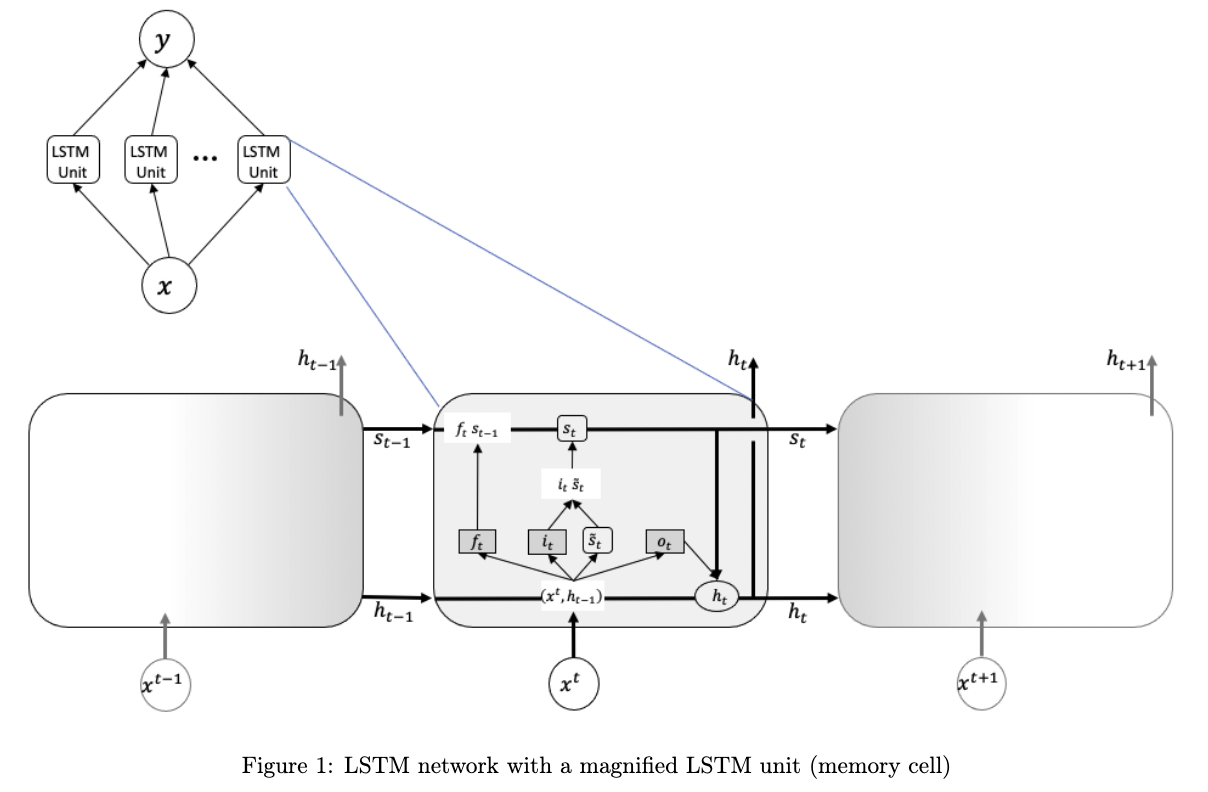

### Notation

- $x = (x_1, x_2, ..., x_n)$ is the input vector where $x_t, t=1, ..., n$ is the data point at time $t$ in a sequence length $n$
- $s_t$ is the cell state, i.e., the memory of the cell at time $t$
- $s_t$ is the candidate cell state
- $h_t$ is the output of the cell, also called the hidden state
- $f_t, i_t$ and $o_t$ are the values for the forget, input and output gates, respectively
- $W_f, W_i, W_o$ and $W_s$ are the weight matrices associated with the input $x$
- $U_f, U_i, U_o$ and $U_s$ are the weight matrices associated with the output $h_t$
- $b_f, b_i, b_o$, and $b_s$ are the bias vectors

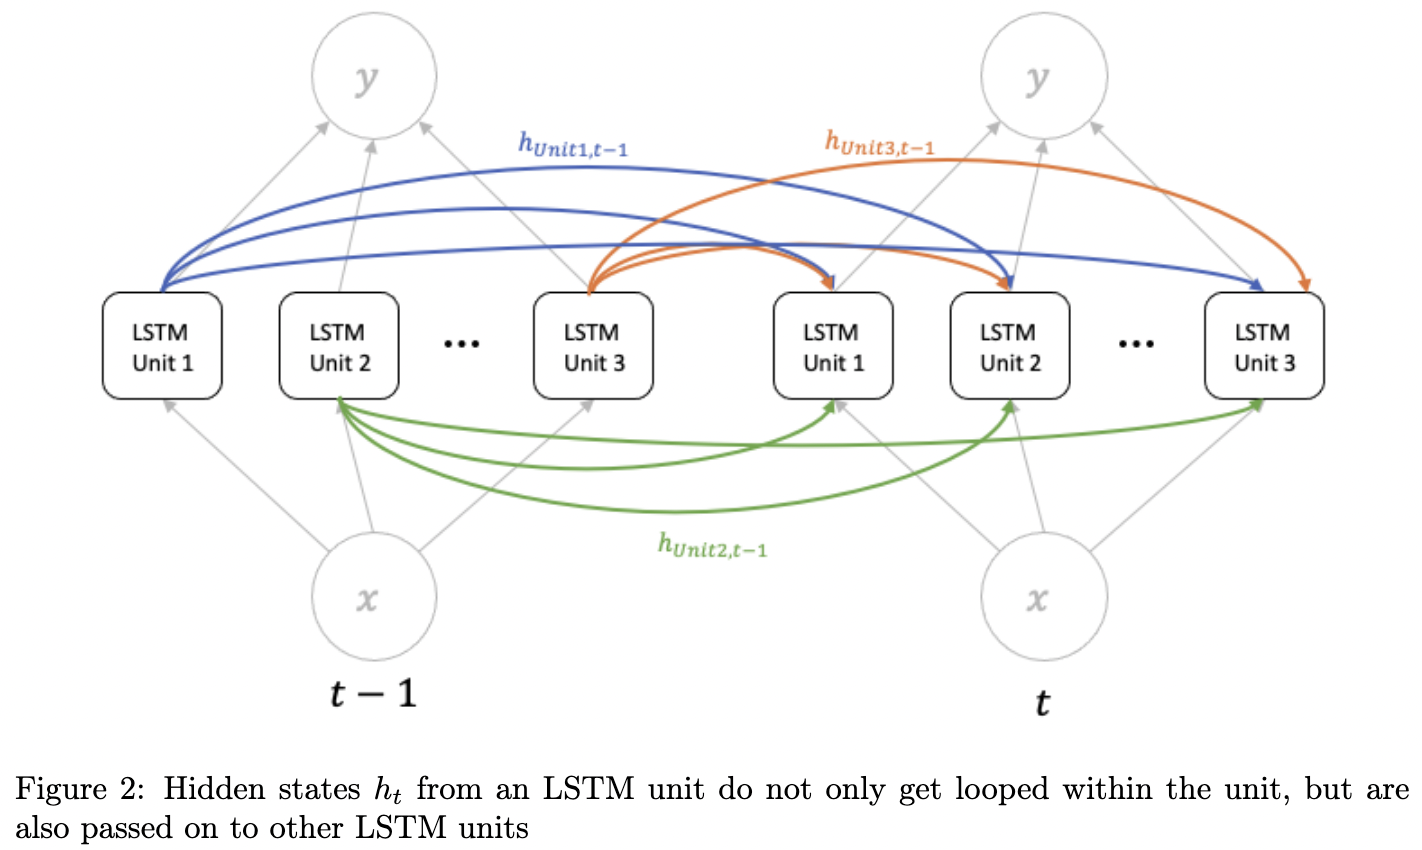

# Outdated

In [7]:
# df.drop(0,  inplace=True)
# df.drop(1,  inplace=True)

In [8]:
# df = df.reset_index(drop=True)

In [9]:
# df.drop('Price', axis=1, inplace=True)

In [10]:
# df['High'] = df['High'].astype(float)
# df['Low'] = df['High'].astype(float)
# df['Close'] = df['High'].astype(float)
#
# df['Typical Price'] = ((df['High']) + (df['Low']) + (df['Close'])) / 3
# time_series = df['Typical Price']

In [11]:
# df['Typical Price'].to_csv('TSLA_TS.csv', index=False, index_label=False, header=False)

In [12]:
# def plot_series(series):
#   """Plots a given pandas Series using matplotlib.
#
#   Args:
#     series: A pandas Series object containing the data to plot.
#   """
#   plt.figure(figsize=(10, 6))  # Adjust figure size as needed
#   plt.plot(series)
#   plt.xlabel("Index")
#   plt.ylabel("Value")
#   plt.title("Time Series Plot")
#   plt.grid(True)
#   plt.show()
#
# # Example usage (assuming 'df' and 'time_series' are defined as in your previous code):
# plot_series(df['Typical Price'])

In [13]:
# def adjustment(input_series):
#     previous = None
#     adjustment = 0
#     adjusted_ts = []
#
#     for point in input_series:
#         if previous is None:
#             pass
#
#         else:
#             difference = abs(point - previous)
#             # Jump from day to day
#             if difference > 5:
#                 if point > previous:
#                     adjustment -= difference
#                 else:
#                     adjustment += difference
#
#         previous = point
#         adjusted_ts.append(point + adjustment)
#         plot_series(adjusted_ts)
#
#     return adjusted_ts

In [14]:
# previous = None
# adjustment = 0
# adjusted_ts = []
#
# for point in df['Typical Price']:
#     if previous is None:
#         # Handle the first point
#         adjusted_ts.append(point)
#         previous = point
#         continue
#
#     difference = abs(point - previous)
#
#     # If we detect a large jump
#     if difference > 15
#
#         print(difference)
#         if point > previous:
#             # If the point jumped up, we need to shift down
#             adjustment -= difference
#         else:
#             # If the point jumped down, we need to shift up
#             adjustment += difference
#
#     # Add the adjusted point
#     adjusted_ts.append(point + adjustment)
#     previous = point  # Store the original (unadjusted) point as previous

In [15]:
# previous = None
# adjustment = 0
# adjusted_ts = []
#
# for point in df['Typical Price']:
#     if previous is None:
#         pass
#
#     else:
#         difference = abs(point - previous)
#
#         # Jump from day to day
#         # if difference > 5:
#         #     print(difference)
#         if difference > 20:
#             if point > previous:
#                 adjustment = -difference
#             else:
#                 adjustment = difference
#
#         # Value is the same
#
#     previous = point
#     adjusted_ts.append(point + adjustment)